<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/McDonald_s_Reviews.csv"

# Lê o arquivo
df = pd.read_csv(url, delimiter=',', encoding='latin-1')
df.head(5)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [4]:
rat=df.rating.value_counts()
rat

5 stars    10274
1 star      9431
4 stars     5787
3 stars     4818
2 stars     3086
Name: rating, dtype: int64

In [5]:
import matplotlib.pyplot as plt

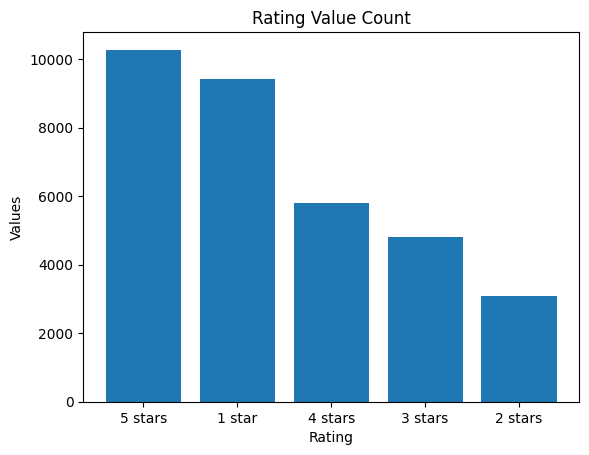

In [6]:
fig, ax = plt.subplots()
ax.bar(rat.index, rat.values)

# Set labels and title
ax.set_xlabel('Rating')
ax.set_ylabel('Values')
ax.set_title('Rating Value Count')

# Display the plot
plt.show()

In [7]:
import re
df["rating"] = df["rating"].str.extract(r"(\d+)", expand=False).astype(int)

In [8]:
mapping={1:0,2:0,3:None,4:1,5:1}
df.rating=df.rating.map(mapping)
df=df.dropna(subset='rating')

In [9]:
df["review"] = df["review"].str.encode("ascii", "ignore").str.decode("utf-8")

<ipython-input-9-3a2fec2ee71e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review"] = df["review"].str.encode("ascii", "ignore").str.decode("utf-8")


In [10]:
df = df[["review", "rating"]]

In [11]:
df.head(10)

,review,rating
0,Why does it look like someone spit on my food?...,0.0
1,It'd McDonalds. It is what it is as far as the...,1.0
2,Made a mobile order got to the speaker and che...,0.0
3,My mc. Crispy chicken sandwich was customer s...,1.0
4,"I repeat my order 3 times in the drive thru, a...",0.0
5,I work for door dash and they locked us all ou...,0.0
6,If I could give this location a zero on custo...,0.0
7,Came in and ordered a Large coffee w/no ice. T...,0.0
8,Went thru drive thru. Ordered. Getting home no...,0.0
9,"I'm not really a huge fan of fast food, but I ...",1.0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.review,df.rating,test_size=0.2)

In [13]:
X_train.shape

(22862,)

In [14]:
X_test.shape

(5716,)

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
print(df.review[5])

I work for door dash and they locked us all out to wait in a long line for no reason at 10. I tried to beg them to open it because I'm door dash and they refused.  Covid is over get a new job


In [17]:
df.review[1]

"It'd McDonalds. It is what it is as far as the food and atmosphere go. The staff here does make a difference. They are all friendly, accommodating and always smiling. Makes for a more pleasant experience than many other fast food places."

In [18]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']
get_sentense_embeding([
    df.review[5],df.review[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8367605 , -0.6208267 , -0.9702623 , ..., -0.8431032 ,
        -0.66128534,  0.9062021 ],
       [-0.6168058 , -0.31054088, -0.91254514, ..., -0.7911302 ,
        -0.5656402 ,  0.80636483]], dtype=float32)>

In [19]:
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [21]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [23]:
model.fit(X_train,y_train,epochs=2)

Epoch 1/2
715/715 [==============================] - 239s 334ms/step - loss: 0.4816 - accuracy: 0.7780 - precision: 0.7780 - recall: 0.8424
Epoch 2/2
715/715 [==============================] - 240s 336ms/step - loss: 0.4058 - accuracy: 0.8228 - precision: 0.8232 - recall: 0.8688


In [24]:
model.evaluate(X_test,y_test)

179/179 [==============================] - 60s 333ms/step - loss: 0.3681 - accuracy: 0.8450 - precision: 0.8327 - recall: 0.9163


[0.36812451481819153,
 0.8449965119361877,
 0.8326923251152039,
 0.9162635803222656]

In [25]:
y_pred=model.predict(X_test)
y_pred=y_pred.flatten()

179/179 [==============================] - 60s 335ms/step


In [26]:
y_pred=np.where(y_pred>0.5,1,0)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)